# **TRAFFIC COLLISION PREDICTION - COLLISION**

**STEP: 1 DATA PREPROCESSING**

In [1]:
import pandas as pd
#Missing Value in data
df = pd.read_excel(r"C:\Users\farhe\Documents\Learning\Ryerson\Certificate\CIND820\Raw\Data_frame.xlsx", na_values = "Missing",sheet_name='Sheet1')
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27894 entries, 0 to 27893
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   INCIDENT INFO  27894 non-null  object        
 1   DESCRIPTION    27894 non-null  object        
 2   START_DT       27894 non-null  datetime64[ns]
 3   MODIFIED_DT    13837 non-null  datetime64[ns]
 4   QUADRANT       13835 non-null  object        
 5   Longitude      27894 non-null  float64       
 6   Latitude       27894 non-null  float64       
 7   location       27649 non-null  object        
 8   Count          27894 non-null  int64         
 9   id             27894 non-null  object        
 10  Point          27894 non-null  object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(6)
memory usage: 2.3+ MB
None


**STEP 2: EXPLORATORY DATA ANALYSIS**

In [3]:
#Check for data type for each attribute
#df.dtypes


#Check min for each attribute
#df.min()

#Check max for each attribute
#df.max()

#Calculate mean for each attribute
#df.mean()

#Calculate standard deviation for each attribute
#df.std()

#Check distinct value for each attribtute
#df.iloc[:,:11].nunique()

#Check missing value for each attribtute
#df.isnull().sum()

#Treat Time in Hours (to identify peak hours of collision) & Days (to identify peak days of collision)
df['hour'] = df.START_DT.dt.hour
df['day'] = df.START_DT.dt.day
df['month'] = df.START_DT.dt.month

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27894 entries, 0 to 27893
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   INCIDENT INFO  27894 non-null  object        
 1   DESCRIPTION    27894 non-null  object        
 2   START_DT       27894 non-null  datetime64[ns]
 3   MODIFIED_DT    13837 non-null  datetime64[ns]
 4   QUADRANT       13835 non-null  object        
 5   Longitude      27894 non-null  float64       
 6   Latitude       27894 non-null  float64       
 7   location       27649 non-null  object        
 8   Count          27894 non-null  int64         
 9   id             27894 non-null  object        
 10  Point          27894 non-null  object        
 11  hour           27894 non-null  int64         
 12  day            27894 non-null  int64         
 13  month          27894 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(4), object(6)
memory usage: 3.

**Box Plots**

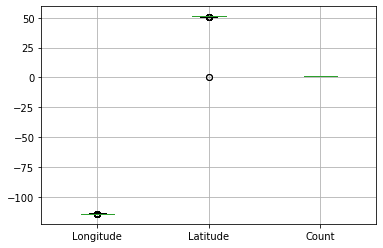

In [4]:
#Identify outliers for numerical columns
df.boxplot(column=['Longitude', 'Latitude', 'Count'])

**Histogram**

(0.0, 2930.0)

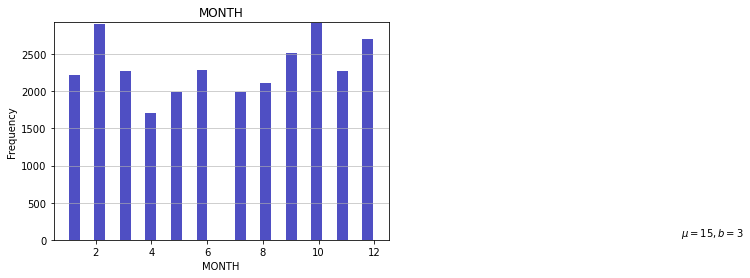

In [4]:
#MOST INCIDENTS OCCUR IN OCTOBER AND FEBRUARY
import matplotlib.pyplot as plt
import numpy as np

n, bins, patches = plt.hist(x=df.iloc[:,13], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('MONTH')
plt.ylabel('Frequency')
plt.title('MONTH')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

(0.0, 2630.0)

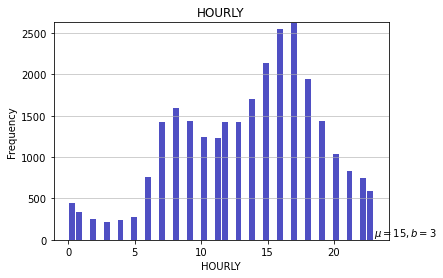

In [5]:
#MOST INCIDENTS OCCUR BETWEEN RUSH HOUR TIME ESPECIALLY BETWEEN 3PM AND 6PM
import matplotlib.pyplot as plt
import numpy as np

n, bins, patches = plt.hist(x=df.iloc[:,11], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('HOURLY')
plt.ylabel('Frequency')
plt.title('HOURLY')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

Text(0.5, 1.0, 'DAY OF THE WEEK')

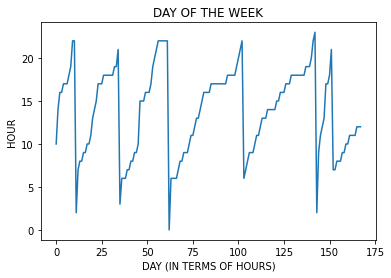

In [8]:
#Hourly data shows cyclical trend best represented as line graph
sample = df[:168] # roughly the first week of the data
ax = sample['hour'].plot()
plt.xlabel('DAY (IN TERMS OF HOURS)')
plt.ylabel('HOUR')
plt.title('DAY OF THE WEEK')


**Correlation**

In [7]:
df.corr()

,Longitude,Latitude,Count,hour,day,month
Longitude,1.000000,-0.023498,NaN,-0.009789,0.003469,0.018018
Latitude,-0.023498,1.000000,NaN,0.003337,-0.010856,-0.007313
Count,NaN,NaN,NaN,NaN,NaN,NaN
hour,-0.009789,0.003337,NaN,1.000000,0.012672,0.032510
day,0.003469,-0.010856,NaN,0.012672,1.000000,0.038882
month,0.018018,-0.007313,NaN,0.032510,0.038882,1.000000


**Step 3: Clustering (DBSCAN)**

In [11]:
#To ensure geopy is installed for location data
#!pip install geopy

#To ensure shapely is installed for location data
#!pip install shapely

In [11]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
from sklearn.cluster import DBSCAN
from sklearn import metrics
import geopy
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
%matplotlib inline

# define the number of kilometers in one radian
kms_per_radian = 6371.0088

In [12]:
# represent points consistently as (lat, lon) and force as type float
coords2 = df.values[:,5:7] 
your_array = coords2.astype(float)
coords = np.exp(your_array)

# define epsilon as 1.5 kilometers, converted to radians for use by haversine
epsilon = 1.5 / kms_per_radian

In [13]:
start_time = time.time()
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_

# get the number of clusters
num_clusters = len(set(cluster_labels))

# all done, print the outcome
message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
print(message.format(len(df), num_clusters, 100*(1 - float(num_clusters) / len(df)), time.time()-start_time))
print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(coords, cluster_labels)))

Clustered 27,894 points down to 8,616 clusters, for 69.1% compression in 39.04 seconds
Silhouette coefficient: -0.564


In [14]:
# turn the clusters in to a pandas series, where each element is a cluster of points
clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])

In [15]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

centermost_points = clusters.map(get_centermost_point)
centermost_points  #8616 clusters

0       (3.0364228819588115e-50, 1.4213234539070235e+22)
1       (2.9061119381350124e-50, 1.5741079331154237e+22)
2       (2.8013370877041646e-50, 1.2818361058248412e+22)
3        (3.008261493038511e-50, 1.4177430648902356e+22)
4        (3.312801570837565e-50, 1.5796717294264374e+22)
                              ...                       
8611     (2.7160781967343332e-50, 1.663053088045348e+22)
8612     (2.786818256379497e-50, 1.4055330814143484e+22)
8613     (2.907419532642269e-50, 1.4009189269777326e+22)
8614     (3.053194464776626e-50, 1.5067517649166438e+22)
8615    (2.7490531342773473e-50, 1.6711749579150396e+22)
Length: 8616, dtype: object

In [16]:
# unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
lats, lons = zip(*centermost_points)

# from these lats/lons create a new df of one representative point for each cluster
rep_points = pd.DataFrame({'Longitude':lons, 'Latitude':lats})
rep_points.tail()

,Longitude,Latitude
8611,1.663053e+22,2.716078e-50
8612,1.405533e+22,2.786818e-50
8613,1.400919e+22,2.907420e-50
8614,1.506752e+22,3.053194e-50
8615,1.671175e+22,2.749053e-50


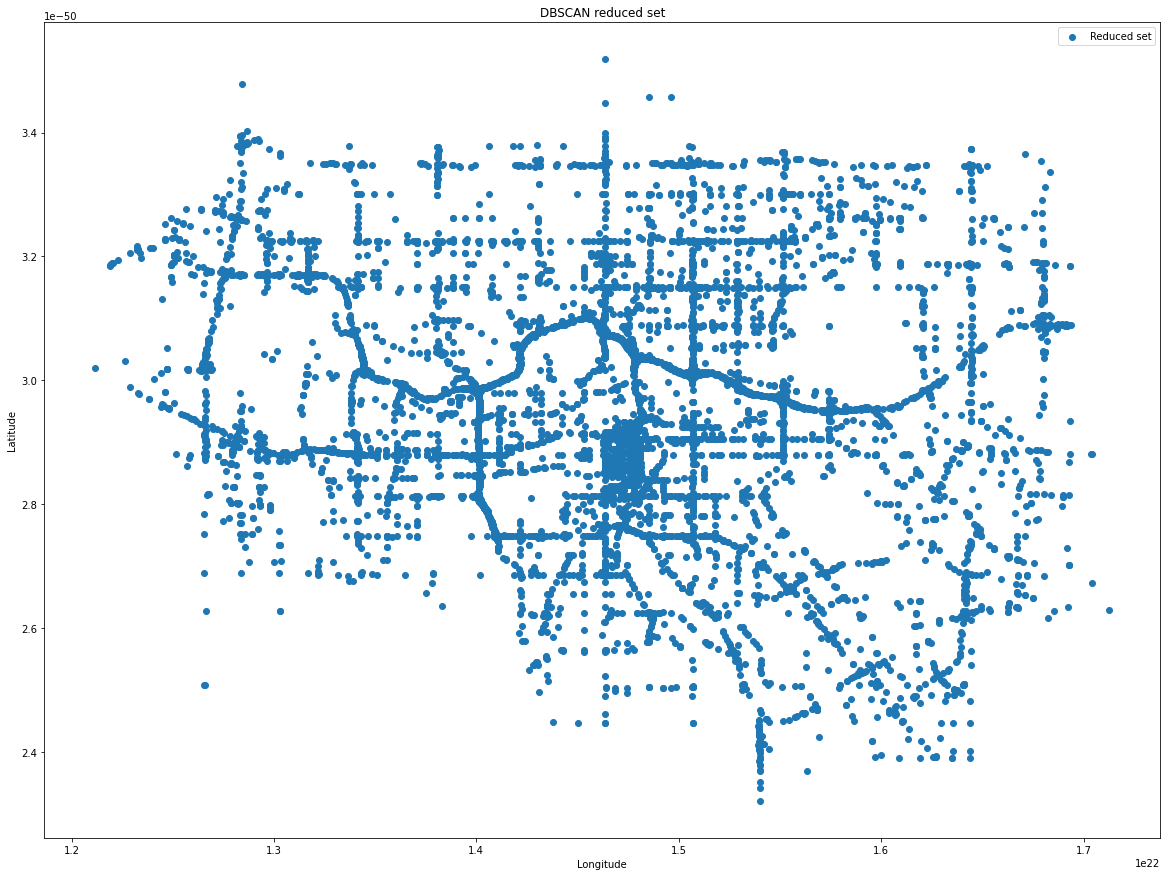

In [10]:
# plot the final reduced set of coordinate points vs the original full set
fig, ax = plt.subplots(figsize=[20, 15])
#rs_scatter = ax.scatter(rep_points['Longitude'], rep_points['Latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
#df_scatter = ax.scatter(df['Longitude'], df['Latitude'], c='k', alpha=0.9, s=3)

rs_scatter = ax.scatter(rep_points['Longitude'], rep_points['Latitude'])
#df_scatter = ax.scatter(df['Longitude'], df['Latitude'])


ax.set_title('DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
ax.legend([rs_scatter], ['Reduced set'], loc='upper right')
plt.show()

**Clustering (K Means)**

In [29]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [30]:
#Elbow Method for optimal value of k means
k_rng= range(1,10)
sse = []
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(df.iloc[:,5:7])
    sse.append(km.inertia_)

In [70]:
#SSE was initially high and kept reducing
sse

[5470.271823933157,
 261.36983555199384,
 168.91112901168646,
 105.1547486397956,
 82.11927625614011,
 66.78080979314056,
 54.902165081306826,
 45.466607430823736,
 40.264127911406625]

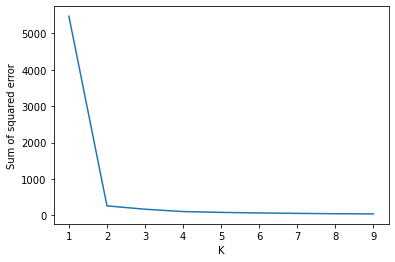

In [72]:
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng,sse)

#Optimal clusters are 2

In [50]:
km = KMeans(n_clusters=3)
km

KMeans(n_clusters=3)

In [51]:
df_KM= df.iloc[:,5:7]
df_KM.head()

,Longitude,Latitude
0,-114.064987,51.096111
1,-114.020548,51.047634
2,-114.058178,51.044471
3,-114.030872,51.028393
4,-114.119584,51.066391


In [52]:
y_predicted = km.fit_predict(df_KM.iloc[:,0:2])
y_predicted

array([0, 2, 2, ..., 0, 0, 0])

In [53]:
df_KM['cluster'] = y_predicted
df_KM.head()



,Longitude,Latitude,cluster
0,-114.064987,51.096111,0
1,-114.020548,51.047634,2
2,-114.058178,51.044471,2
3,-114.030872,51.028393,2
4,-114.119584,51.066391,0


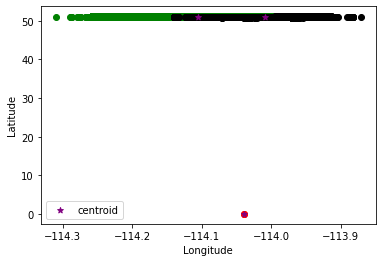

In [54]:
df1 = df_KM[df_KM.cluster ==0]
df2 = df_KM[df_KM.cluster ==1]
df3 = df_KM[df_KM.cluster ==2]
df4 = df_KM[df_KM.cluster ==3]
plt.scatter(df1['Longitude'],df1['Latitude'],color='green')
plt.scatter(df2['Longitude'],df2['Latitude'],color='red')
plt.scatter(df3['Longitude'],df3['Latitude'],color='black')
plt.scatter(df4['Longitude'],df4['Latitude'],color='blue')
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='purple',marker="*",label='centroid')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

In [187]:
from sklearn.metrics import silhouette_samples, silhouette_score
start_time = time.time()
score = silhouette_score(df_KM.iloc[:,0:2], km.labels_, metric='euclidean')
#
# Print the score
#
print("The average silhouette_score is: %.3f" % score)
print("The time taken",time.time()-start_time)
#For n_cluster ==2, The average silhouette_score is: 0.998


The average silhouette_score is: 0.998
13.834924221038818


**STEP 4: Feature Engineering & Selection**

In [82]:
#We start seperating the class attribute which is the column DESCRIPTION
df['DESCRIPTION'].value_counts()

Two vehicle incident.                                                          7580
Traffic incident.                                                              3298
Single vehicle incident.                                                       2290
Multi-vehicle incident.                                                        1386
Two vehicle incident. Blocking the right lane                                   749
                                                                               ... 
There is an incident involving a cyclist. The road is now open                    1
Canadian Pacific rail crossing issues, expect delays in the area.                 1
Ongoing Incident, the road is closed EB and WB                                    1
Traffic incident.    The road is closed southbound, westbound and eastbound       1
Multi-vehicle incident.  Blocking the left turning lane.                          1
Name: DESCRIPTION, Length: 3488, dtype: int64

In [19]:
#We identify the top 4 classes as either 'Two vehicle incident', 'Single vehicle incident','Multi-vehicle incident' 
#or just 'Traffic Incident'. We then isolate them as seperate data frames

class_1b=df[(df['DESCRIPTION']=='Two vehicle incident.')].reset_index(drop=True)
class_1b['output_class']=1

class_1 = class_1b.iloc[:,5:7]


class_2b=df[(df['DESCRIPTION']=='Traffic incident.')].reset_index(drop=True)
class_2b['output_class']=2

class_2 = class_2b.iloc[:,5:7]

class_3b=df[(df['DESCRIPTION']=='Single vehicle incident.')].reset_index(drop=True)
class_3b['output_class']=3

class_3 = class_3b.iloc[:,5:7]

class_4b=df[(df['DESCRIPTION']=='Multi-vehicle incident.')].reset_index(drop=True)
class_4b['output_class']=4

class_4 = class_4b.iloc[:,5:7]

#We have shortlisted our input features to 1.Longitude 2.Latitude for each DESCRIPTION type

#### Randomly shuffling the dataset

In [20]:
class_1=class_1.sample(frac=1, random_state=7).reset_index(drop=True)
class_2=class_2.sample(frac=1, random_state=7).reset_index(drop=True)
class_3=class_3.sample(frac=1, random_state=7).reset_index(drop=True)
class_4=class_4.sample(frac=1, random_state=7).reset_index(drop=True)

In [22]:
class_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3298 entries, 0 to 3297
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Longitude  3298 non-null   float64
 1   Latitude   3298 non-null   float64
dtypes: float64(2)
memory usage: 51.7 KB


In [23]:
#Run DBSCAN for each DESCRIPTION type

#class_1
coords2 = class_1.values[:,0:2] 
your_array = coords2.astype(float)
coords = np.exp(your_array)

start_time = time.time()
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_

# get the number of clusters
num_clusters = len(set(cluster_labels))

# all done, print the outcome
message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
print(message.format(len(class_1), num_clusters, 100*(1 - float(num_clusters) / len(class_1)), time.time()-start_time))
print('For class_1, Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(coords, cluster_labels)))

clusters_class_1 = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])

#class_2
coords2 = class_2.values[:,0:2] 
your_array = coords2.astype(float)
coords = np.exp(your_array)

start_time = time.time()
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_

# get the number of clusters
num_clusters = len(set(cluster_labels))

# all done, print the outcome
message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
print(message.format(len(class_2), num_clusters, 100*(1 - float(num_clusters) / len(class_2)), time.time()-start_time))
print('For class_2, Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(coords, cluster_labels)))

clusters_class_2 = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])

#class_3
coords2 = class_3.values[:,0:2] 
your_array = coords2.astype(float)
coords = np.exp(your_array)

start_time = time.time()
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_

# get the number of clusters
num_clusters = len(set(cluster_labels))

# all done, print the outcome
message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
print(message.format(len(class_3), num_clusters, 100*(1 - float(num_clusters) / len(class_3)), time.time()-start_time))
print('For class_3, Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(coords, cluster_labels)))

clusters_class_3 = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])

#class_4
coords2 = class_4.values[:,0:2] 
your_array = coords2.astype(float)
coords = np.exp(your_array)

start_time = time.time()
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_

# get the number of clusters
num_clusters = len(set(cluster_labels))

# all done, print the outcome
message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
print(message.format(len(class_4), num_clusters, 100*(1 - float(num_clusters) / len(class_4)), time.time()-start_time))
print('For class_4, Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(coords, cluster_labels)))

clusters_class_4 = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])

Clustered 7,580 points down to 3,774 clusters, for 50.2% compression in 2.83 seconds
For class_1, Silhouette coefficient: -0.018
Clustered 3,298 points down to 2,064 clusters, for 37.4% compression in 0.57 seconds
For class_2, Silhouette coefficient: 0.268
Clustered 2,290 points down to 1,474 clusters, for 35.6% compression in 0.28 seconds
For class_3, Silhouette coefficient: 0.157
Clustered 1,386 points down to 1,001 clusters, for 27.8% compression in 0.12 seconds
For class_4, Silhouette coefficient: 0.162


In [24]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

centermost_points_class_1 = clusters_class_1.map(get_centermost_point)
centermost_points_class_2 = clusters_class_2.map(get_centermost_point)
centermost_points_class_3 = clusters_class_3.map(get_centermost_point)
centermost_points_class_4 = clusters_class_4.map(get_centermost_point)

In [25]:
#class_1

lats1, lons1 = zip(*centermost_points_class_1)
rep_points_class_1 = pd.DataFrame({'Longitude':lons1, 'Latitude':lats1})

#class_2

lats2, lons2 = zip(*centermost_points_class_2)
rep_points_class_2 = pd.DataFrame({'Longitude':lons2, 'Latitude':lats2})

#class_3

lats3, lons3 = zip(*centermost_points_class_3)
rep_points_class_3 = pd.DataFrame({'Longitude':lons3, 'Latitude':lats3})

#class_4

lats4, lons4 = zip(*centermost_points_class_4)
rep_points_class_4 = pd.DataFrame({'Longitude':lons4, 'Latitude':lats4})


Text(0.5, 1.0, 'Multi-vehicle incident')

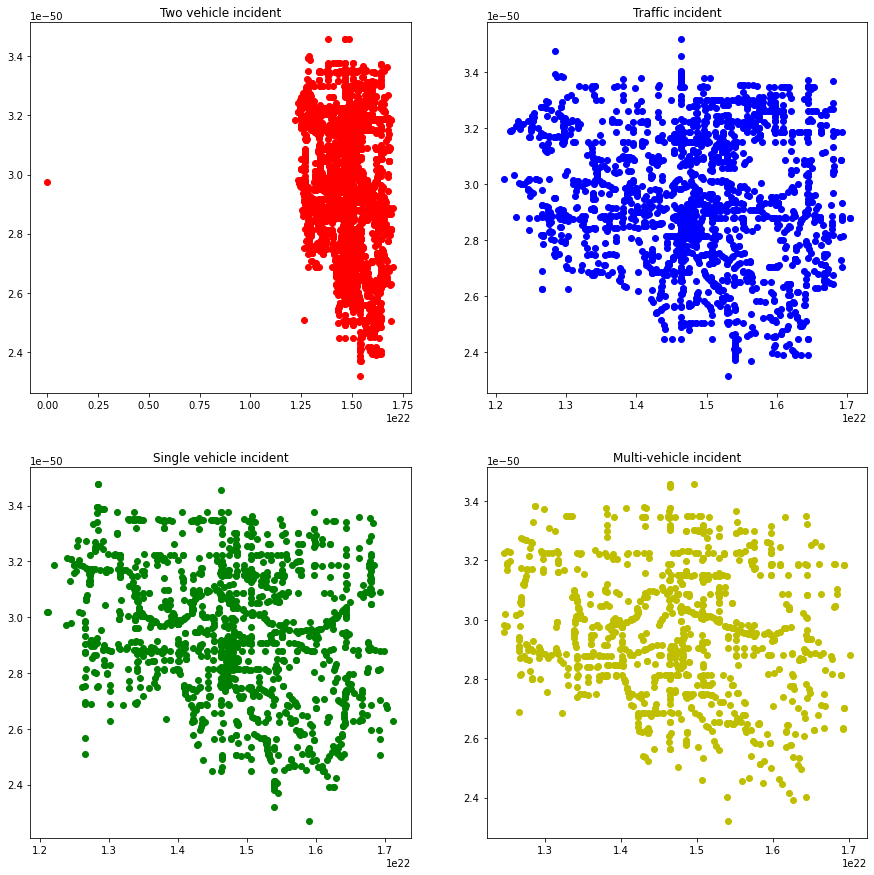

In [26]:
plt.subplots(figsize=[15, 15])

plt.subplot(2,2,1)
plt.plot(rep_points_class_1['Longitude'], rep_points_class_1['Latitude'],'ro')
plt.title('Two vehicle incident')


plt.subplot(2,2,2)
plt.plot(rep_points_class_2['Longitude'], rep_points_class_2['Latitude'],'bo')
plt.title('Traffic incident')

plt.subplot(2,2,3)
plt.plot(rep_points_class_3['Longitude'], rep_points_class_3['Latitude'],'go')
plt.title('Single vehicle incident')

plt.subplot(2,2,4)
plt.plot(rep_points_class_4['Longitude'], rep_points_class_4['Latitude'],'yo')
plt.title('Multi-vehicle incident')

**Step 5: Model Evaluation**

In [ ]:
# DBSCAN Vs KMeans
# Clusters:
#     DBSCAN:8,616
#     KMeans : 2
# Time (s):
#     DBSCAN: 67.56s
#     KMeans: 13.83
# Silhouette Coefficient:
#     DBSCAN: -0.564
#     KMeans: 0.998

#Visualization shows that Kmeans provides a hotspot of 2 clusters around 2 centroids. 
#DBSCAN shows us 8,616 clusters scattered across the City with some places having higher density traffic incidents than others
#Additionally the number of clusters for KMeans had to be pre-set.


In [55]:
# DBSCAN with Feature Engineering
# Clusters:
#     Feature 1: 3,774
#     Feature 2: 2,064
#     Feature 3: 1,474
#     Feature 4: 1,001
# Time (s):
#     Feature 1: 2.71
#     Feature 2: 0.50
#     Feature 3: 0.25
#     Feature 4: 0.11
        
# Silhouette coefficient:
#     Feature 1: -0.018
#     Feature 2:  0.268
#     Feature 3:  0.157
#     Feature 4:  0.162
